<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4 Dengue cases in Singapore by eweeks modelling/ prediction


In this script, we attempt to fit a Regression model to predict the number of dengue cases (y variable) depending on the various x variables ( 

##  Read in Libraries

In [112]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import statsmodels.api as sm

import math
import sklearn.metrics
from sklearn import datasets, ensemble
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV 
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.inspection import permutation_importance

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('../data/Output after Merged.xlsx')

In [3]:
df.head()


,epi_week_year,start,dengue_cases,Year,Month,Day,total_rainfall,rainfall_30min,rainfall_60min,rainfall_120min,...,temperature_max,temperature_min,windspeed_mean,windspeed_max,Date,Epiweek,Town,Region,freq_dengue_gtrends,freq_wolbachia_gtrends
0,2013-W21,19/5/2013,0,2013,5,19,52.8,4.218408,5.170072,5.854992,...,34.9,22.7,4.100000,38.9,19/5/2013,2013-W21,ang mo kio,Central,114.186851,0.0
1,2013-W22,26/5/2013,0,2013,5,26,56.2,4.218408,5.170072,5.854992,...,34.3,23.0,4.371429,64.8,26/5/2013,2013-W22,ang mo kio,Central,530.153238,0.0
2,2013-W23,2/6/2013,23,2013,6,2,123.8,3.740979,4.576394,5.233173,...,35.5,23.2,4.357143,48.2,2/6/2013,2013-W23,ang mo kio,Central,424.122590,0.0
3,2013-W24,9/6/2013,23,2013,6,9,8.8,3.740979,4.576394,5.233173,...,34.1,24.2,6.328571,39.2,9/6/2013,2013-W24,ang mo kio,Central,815.620366,0.0
4,2013-W25,16/6/2013,11,2013,6,16,1.0,3.740979,4.576394,5.233173,...,34.6,26.8,6.300000,43.9,16/6/2013,2013-W25,ang mo kio,Central,530.153238,0.0


In [4]:
df['Month'].unique()

array([ 5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4])

In [5]:
#Convert 'Month' into a categorical variable
df['Month'] = df['Month'].apply(lambda x:str(x)) 

In [6]:
df.dtypes

epi_week_year              object
start                      object
dengue_cases                int64
Year                        int64
Month                      object
Day                         int64
total_rainfall            float64
rainfall_30min            float64
rainfall_60min            float64
rainfall_120min           float64
temperature_mean          float64
temperature_max           float64
temperature_min           float64
windspeed_mean            float64
windspeed_max             float64
Date                       object
Epiweek                    object
Town                       object
Region                     object
freq_dengue_gtrends       float64
freq_wolbachia_gtrends    float64
dtype: object

At this point, we wish to do some EDA on the individual Towns in df so that we see if there are any 

Since 'Town' and 'Region' are perfectly correlated, we want to choose 1 to be in the model and one-hot encoded as dummies, while the other one should be dropped. We also drop the variables 'epi_week_year', 'start' (start date of week), 'Date' and 'Year' as they denote time variables which are not important in a model that is not time series modelling (ARIMA)

In [7]:
df_sub = df.drop(columns = ['epi_week_year','start','Date','Epiweek','Town','Year','Day'])
df_dummies = pd.get_dummies(df_sub, drop_first=False)

In [15]:
df_dummies['dengue_cases_log'] = np.log1p(df_dummies['dengue_cases'])
df_dummies.drop(columns=['dengue_cases'], inplace = True)

In [16]:
list_to_log = ['total_rainfall', 'rainfall_30min', 'rainfall_60min', 'rainfall_120min', 
               'temperature_mean', 'temperature_max' , 'temperature_min', 'windspeed_mean', 'windspeed_max']

In [17]:
df_dummies_new = df_dummies

In [18]:
for x in list_to_log:
    df_dummies_new[x] = np.log1p(df_dummies_new[x])

In [19]:
df_dummies_new['total_rainfall'].head()

0    3.985273
1    4.046554
2    4.826712
3    2.282382
4    0.693147
Name: total_rainfall, dtype: float64

In [14]:
df_dummies['total_rainfall'].head()

0     52.8
1     56.2
2    123.8
3      8.8
4      1.0
Name: total_rainfall, dtype: float64

In [79]:
df_dummies_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9494 entries, 0 to 9493
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   total_rainfall          9494 non-null   float64
 1   rainfall_30min          9494 non-null   float64
 2   rainfall_60min          9494 non-null   float64
 3   rainfall_120min         9494 non-null   float64
 4   temperature_mean        9494 non-null   float64
 5   temperature_max         9494 non-null   float64
 6   temperature_min         9494 non-null   float64
 7   windspeed_mean          9494 non-null   float64
 8   windspeed_max           9494 non-null   float64
 9   freq_dengue_gtrends     9494 non-null   float64
 10  freq_wolbachia_gtrends  9494 non-null   float64
 11  Month_1                 9494 non-null   uint8  
 12  Month_10                9494 non-null   uint8  
 13  Month_11                9494 non-null   uint8  
 14  Month_12                9494 non-null   

In [20]:
df_dummies_new.shape

(9494, 30)

Train-Test Split

In [22]:
y = df_dummies_new['dengue_cases_log']
X = df_dummies_new.drop(columns = 'dengue_cases_log', axis = 1, inplace = False, errors = 'raise')

In [23]:
print(y.shape)
print(X.shape)
print(X.dtypes)

(9494,)
(9494, 29)
total_rainfall            float64
rainfall_30min            float64
rainfall_60min            float64
rainfall_120min           float64
temperature_mean          float64
temperature_max           float64
temperature_min           float64
windspeed_mean            float64
windspeed_max             float64
freq_dengue_gtrends       float64
freq_wolbachia_gtrends    float64
Month_1                     uint8
Month_10                    uint8
Month_11                    uint8
Month_12                    uint8
Month_2                     uint8
Month_3                     uint8
Month_4                     uint8
Month_5                     uint8
Month_6                     uint8
Month_7                     uint8
Month_8                     uint8
Month_9                     uint8
Region_Central              uint8
Region_East                 uint8
Region_North                uint8
Region_North East           uint8
Region_South                uint8
Region_West                 u

In [24]:
# Split the data into the training and testing sets for normal tokenized words
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

## Using Pipeline

In [43]:
def run_pipline(items, X_train, X_test, y_train, y_test):

    # Add a pipe, add a param !
    pipe_items = {
        'rs' : RobustScaler(),
        'ss' : StandardScaler(),
        'pf' : PolynomialFeatures(),
        'lr' : LinearRegression(),
        'rd' : Ridge(),
        'la' : Lasso(),
        'en' : ElasticNet(), 
        'rf' : RandomForestRegressor(),
        'gb' : GradientBoostingRegressor(),
        'ab' : AdaBoostRegressor(),
        'svm' : SVR(),
        'knn' : KNeighborsRegressor(),
    }   
    
    param_items = {
        'ss' : {
            'ss__with_mean' : [False]
        },
        'rs' : {
            
        },
        'pf' : {
            'pf__degree' : [2]
        },
        'lr' : {
            'lr__n_jobs' : [1]
        },
        'rd' : {
             'rd__alpha' : [55.0, 60.0, 65.0]
        },
        'la' : {
             'la__alpha' : [0.005, 0.0075, 0.01], 
             'la__max_iter' : [100000]
        },
        'en' : {
             'en__alpha' : [0.01, 0.02, 0.4], 
             'en__l1_ratio' : [.8, 1, 1.2]
        },
        'rf' : {
            'rf__n_estimators' : [7, 8, 9]
        },
        'gb' : {
            'gb__max_depth': [4,5],
            'gb__n_estimators': [335, 340, 345],
            'gb__learning_rate': [.1, .12]
        },
        'ab' : {
            'ab__n_estimators' : [65, 70, 75]
        },
        'svm' : {
            'svm__kernel' : ['linear','poly']
        },
        'knn' : {
            'knn__n_neighbors' : [3, 4, 5, 6]
        }

    }

    # Create the parameters for GridSearch
    params = dict()
    for i in items:
        for p in param_items[i]:
            params[p] = param_items[i][p]

    # Create the pipeline
    pipe_list = [(i,pipe_items[i]) for i in items]
    print("Using:")
    for p in pipe_list:
        print("\t" + str(p[1]).split('(')[0])
    pipe = Pipeline(pipe_list)

    # Grid search
    gs = GridSearchCV(pipe, param_grid=params, verbose=1)
    gs.fit(X_train, y_train)

    # Print the results
    train_params = gs.best_params_
    train_score = gs.best_score_
    y_test_hat = gs.predict(X_test)
    test_score = gs.score(X_test, y_test)
    MSE = np.square(np.subtract(y_test,y_test_hat)).mean() 
    RMSE = math.sqrt(MSE)

    for k in train_params:
        print("{}: {}".format(k,train_params[k]))

    print("Train score: {} \nTest score: {} \nRMSE: {}".format(train_score, test_score, RMSE))
    print("")

    return train_score, test_score, y_test_hat, train_params, RMSE

In [47]:
models = ['lr','rd','la','en','rf','gb','ab']

model_solns = {}
for m in models:
    pipe_items = ['rs', m]
    [train_score, test_score, y_test_hat, best_params, RMSE] = run_pipline(pipe_items, X_train, X_test, y_train, y_test)
    model_solns = {'model': m, 'train_score': train_score, 'test_score': test_score, 
                   'best_params': best_params, 'y_test_hat' : y_test_hat, 'RMSE' : RMSE}

Using:
	RobustScaler
	LinearRegression
Fitting 5 folds for each of 1 candidates, totalling 5 fits
lr__n_jobs: 1
Train score: 0.13611817173992774 
Test score: 0.13355695534471523 
RMSE: 1.394161133515968

Using:
	RobustScaler
	Ridge
Fitting 5 folds for each of 3 candidates, totalling 15 fits
rd__alpha: 55.0
Train score: 0.13701888501678866 
Test score: 0.1341746850870339 
RMSE: 1.3936640619782696

Using:
	RobustScaler
	Lasso
Fitting 5 folds for each of 3 candidates, totalling 15 fits
la__alpha: 0.005
la__max_iter: 100000
Train score: 0.13660952204763727 
Test score: 0.1325066529818455 
RMSE: 1.3950058787402417

Using:
	RobustScaler
	ElasticNet
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py", line 925, in f

en__alpha: 0.01
en__l1_ratio: 0.8
Train score: 0.13433789493293877 
Test score: 0.1309764670481426 
RMSE: 1.396235673693426

Using:
	RobustScaler
	RandomForestRegressor
Fitting 5 folds for each of 3 candidates, totalling 15 fits
rf__n_estimators: 8
Train score: 0.2533647757923979 
Test score: 0.27998863086728665 
RMSE: 1.270903683529671

Using:
	RobustScaler
	GradientBoostingRegressor
Fitting 5 folds for each of 12 candidates, totalling 60 fits
gb__learning_rate: 0.12
gb__max_depth: 5
gb__n_estimators: 335
Train score: 0.37255469562120297 
Test score: 0.36866466484630767 
RMSE: 1.1900713770256144

Using:
	RobustScaler
	AdaBoostRegressor
Fitting 5 folds for each of 3 candidates, totalling 15 fits
ab__n_estimators: 70
Train score: 0.02085247406219637 
Test score: 0.06429103517661117 
RMSE: 1.4488164107356158



In [44]:
models = ['lr','rd','la','en','rf','gb','ab']

model_solns = {}
for m in models:
    pipe_items = ['ss', m]
    [train_score, test_score, y_test_hat, best_params, RMSE] = run_pipline(pipe_items, X_train, X_test, y_train, y_test)
    model_solns = {'model': m, 'train_score': train_score, 'test_score': test_score, 
                   'best_params': best_params, 'y_test_hat' : y_test_hat, 'RMSE' : RMSE}

Using:
	StandardScaler
	LinearRegression
Fitting 5 folds for each of 1 candidates, totalling 5 fits
lr__n_jobs: 1
ss__with_mean: False
Train score: 0.13611817173992788 
Test score: 0.13355695534471534 
RMSE: 1.3941611335159676

Using:
	StandardScaler
	Ridge
Fitting 5 folds for each of 3 candidates, totalling 15 fits
rd__alpha: 65.0
ss__with_mean: False
Train score: 0.1367825238144447 
Test score: 0.13327987678426356 
RMSE: 1.3943840340772216

Using:
	StandardScaler
	Lasso
Fitting 5 folds for each of 3 candidates, totalling 15 fits
la__alpha: 0.0075
la__max_iter: 100000
ss__with_mean: False
Train score: 0.137389995779492 
Test score: 0.13271731363953898 
RMSE: 1.3948364879893047

Using:
	StandardScaler
	ElasticNet
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py", line 925, in f

en__alpha: 0.01
en__l1_ratio: 0.8
ss__with_mean: False
Train score: 0.13739100138827387 
Test score: 0.13267545156059923 
RMSE: 1.3948701506298136

Using:
	StandardScaler
	RandomForestRegressor
Fitting 5 folds for each of 3 candidates, totalling 15 fits
rf__n_estimators: 9
ss__with_mean: False
Train score: 0.26779130151265174 
Test score: 0.2934373861792243 
RMSE: 1.2589784269811148

Using:
	StandardScaler
	GradientBoostingRegressor
Fitting 5 folds for each of 12 candidates, totalling 60 fits
gb__learning_rate: 0.12
gb__max_depth: 5
gb__n_estimators: 340
ss__with_mean: False
Train score: 0.3758968942079318 
Test score: 0.34687905943767694 
RMSE: 1.2104302415711468

Using:
	StandardScaler
	AdaBoostRegressor
Fitting 5 folds for each of 3 candidates, totalling 15 fits
ab__n_estimators: 65
ss__with_mean: False
Train score: 0.02137576257369449 
Test score: 0.0406772804645229 
RMSE: 1.4669838285088495



### Key Metrics used for model evaluation: Accuracy and RMSE 

The key metric we are using to evaluate the model is accuracy. 

In this regression problem, 


In [60]:
pipe = Pipeline([
    ('rs', RobustScaler()),
    ('gb', GradientBoostingRegressor())
])
params_grid_cv = {
    'gb__max_depth': [6, 7, 8],
    'gb__n_estimators': [340, 345],
    'gb__learning_rate': [.08, .1]
}

gs = GridSearchCV(pipe, param_grid=params_grid_cv, verbose=1)
gs.fit(X_train, y_train)
y_hat = gs.predict(X_test)

print("Train score: {} Test score: {}".format(gs.score(X_train,y_train),gs.score(X_test,y_test))) 

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Train score: 0.8064420437935268 Test score: 0.37067656738899424


In [61]:
gs.best_params_

{'gb__learning_rate': 0.08, 'gb__max_depth': 6, 'gb__n_estimators': 340}

In [62]:
MSE = np.square(np.subtract(y_test,y_hat)).mean() 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

1.188173638968412


Gradient Boosting and Standard Scaler


****First Run****

Fitting 5 folds for each of 27 candidates, totalling 135 fits<br>
Train score: 0.6530098540090052<br>
Test score: 0.3391995732120534<br>
Root Mean Square Error: 1.2212522144824338<br>
{'gb__learning_rate': 0.12,
 'gb__max_depth': 4,
 'gb__n_estimators': 335,
 'ss__with_mean': False}


****Second Run****

Fitting 5 folds for each of 27 candidates, totalling 135 fits<br>
Train score: 0.7681231189322599<br>
Test score: 0.34670315866288015<br>
Root Mean Square Error: 1.210593229212674<br>
{'gb__learning_rate': 0.12,
 'gb__max_depth': 5,
 'gb__n_estimators': 340,
 'ss__with_mean': False}


****Third Run****

Fitting 5 folds for each of 27 candidates, totalling 135 fits<br>
Train score: 0.7673046824845974<br>
Test score: 0.37014414601899304<br>
Root Mean Square Error: 1.2083828882031362<br>
{'gb__learning_rate': 0.12,
 'gb__max_depth': 5,
 'gb__n_estimators': 340,
 'ss__with_mean': False}
 
 
****Fourth Run****

Fitting 5 folds for each of 27 candidates, totalling 135 fits<br>
Train score: 0.765139363087981<br>
Test score: 0.34908660259032187<br>
Root Mean Square Error: 1.1886761431341473<br>
{'gb__learning_rate': 0.12,
 'gb__max_depth': 5,
 'gb__n_estimators': 335,
 'ss__with_mean': False}
 
 
****Fifth Run****

Fitting 5 folds for each of 27 candidates, totalling 135 fits<br>
Train score: 0.648608968357324<br>
Test score: 0.35593158571535377<br>
Root Mean Square Error: 1.2020124394297025<br>
{'gb__learning_rate': 0.12,
 'gb__max_depth': 4,
 'gb__n_estimators': 340,
 'ss__with_mean': False}

Gradient Boosting and Robust Scaler


****First Run****

Fitting 5 folds for each of 27 candidates, totalling 135 fits<br>
Train score: 0.8095073061520071<br>
Test score: 0.3664585457709003<br>
Root Mean Square Error: 1.1921488384432333<br>
{'gb__learning_rate': 0.08,
 'gb__max_depth': 6,
 'gb__n_estimators': 345}
 
****Second Run****

Fitting 5 folds for each of 27 candidates, totalling 135 fits<br>
Train score: 0.8849177969390806<br>
Test score: 0.3605732161277968<br>
Root Mean Square Error: 1.1976733149778471<br>
{'gb__learning_rate': 0.08,
 'gb__max_depth': 7,
 'gb__n_estimators': 345}
 
****Third Run****

Fitting 5 folds for each of 27 candidates, totalling 135 fits<br>
Train score: 0.8064420437935268<br>
Test score: 0.37067656738899424<br>
Root Mean Square Error: 1.188173638968412<br>
{'gb__learning_rate': 0.08,
 'gb__max_depth': 6,
 'gb__n_estimators': 340}

In [64]:
gs.best_estimator_.named_steps["gb"].feature_importances_

array([0.07185771, 0.05877523, 0.05381819, 0.06408461, 0.04610814,
       0.05710768, 0.03849757, 0.08168998, 0.03659142, 0.19968321,
       0.0563222 , 0.00369736, 0.00911347, 0.0034108 , 0.00271224,
       0.00223482, 0.00496791, 0.00280916, 0.00745167, 0.00344167,
       0.01096777, 0.0128909 , 0.01246349, 0.03849442, 0.0358829 ,
       0.01869506, 0.01459208, 0.01757425, 0.03406412])

In [66]:
rc = RobustScaler()
Z_train = rc.fit_transform(X_train)
Z_test = rc.transform(X_test)

In [69]:
gboost = GradientBoostingRegressor(learning_rate=0.08, n_estimators=340, max_depth=6)
gboost.fit(Z_train, y_train)
z_hat = gboost.predict(Z_test)
MSE = np.square(np.subtract(y_test,z_hat)).mean() 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:")
print(RMSE)

Root Mean Square Error:

1.1933447544941702


In [70]:
print(gboost.score(Z_train, y_train))
print(gboost.score(Z_test, y_test))

0.7952129169720092
0.3651868213051085


/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-pack

/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-pack

/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-pack

/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-pack

/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/Users/cindy/opt/anaconda3/lib/python3.9/site-pack

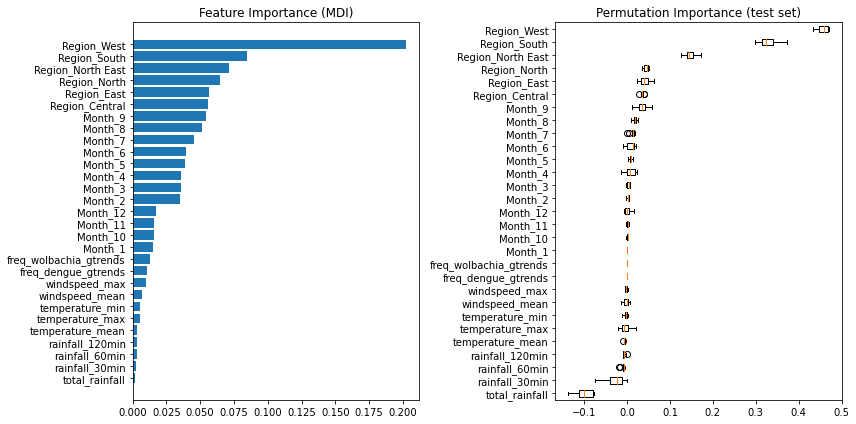

In [113]:
feature_importance = gboost.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns))
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    gboost, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X.columns),
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## Conclusions and Recommendations

****Conclusion****
For our final model, we decided to go with Gradient Boosting Regression and our test score is 0.795 and train score is 0.365. Although the model seems to be overfitted, but we can still gather certain information from features importance. We notice that West region have the most effect on influencing the dengue cases.

What we are lacking will be different type of dataset, such as humidity, which might be more vital in forecasting dengue cases.